## 지난주 개념 복습!
아래 마크다운을 풀고, 지난주 예습과제를 통해 공부한 Vision Transformer의 특징과 다른 모델들과의 차이점을 간략히 설명해주세요.

- ViT는 고정 패치 + 선형 임베딩으로 전역 MHSA를 쓰는 평탄 구조, 인덕티브 바이어스가 약해 대규모 프리트레인에 특히 강함.
CvT는 임베딩/어텐션에 컨볼루션을 주입하고 피라미드(계층) 구조를 채택해 지역성·데이터 효율을 높여 중소규모 데이터/밀집 과제에 유리함.
- ViT는 전역 MHSA(복잡도 O(N²))와 절대 위치 인코딩을 써서 단순 분류에 적합하나 해상도 변화엔 취약함.Swin은 윈도우+Shifted Window로 지역 어텐션을 하고 계층적 다운샘플을 적용해, 검출·분할 등 멀티스케일 작업에서 메모리/속도와 성능의 균형이 좋음.

## 파이토치로 구현한 Vision Transformer
이번 복습과제에서는 카사바 잎 질병 데이터셋으로 vision transformer를 학습시키겠습니다.
- 첨부된 드라이브에서 필요한 파일들을 다운받을 수 있습니다.

In [1]:
# PyTorch 2.4 계열 + XLA 2.4 계열 (권장 예시)
%pip install -U "torch~=2.4.0" "torchvision~=0.19.0" "torchaudio~=2.4.0" -f https://storage.googleapis.com/libtpu-releases/index.html
%pip install -U "torch-xla[tpu]~=2.4.0" -f https://storage.googleapis.com/libtpu-releases/index.html
%pip install -U timm


Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
Looking in links: https://storage.googleapis.com/libtpu-releases/index.html
ERROR: Could not find a version that satisfies the requirement torch-xla~=2.4.0 (from versions: 2.8.0, 2.8.1)
ERROR: No matching distribution found for torch-xla~=2.4.0


### 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#.zip 파일 unzip
#본인 드라이브의 경로에 맞게 수정해주세요!
!unzip /content/drive/MyDrive/Euron_9thDL/week9/train_images -d /content/drive/MyDrive/Euron_9thDL/week9/train_images

Archive:  /content/drive/MyDrive/Euron_9thDL/week9/train_images.zip
replace /content/drive/MyDrive/Euron_9thDL/week9/train_images/1000015157.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace /content/drive/MyDrive/Euron_9thDL/week9/train_images/1000201771.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
#본인 드라이브의 경로에 맞게 수정해주세요!
!unzip /content/drive/MyDrive/Euron_9thDL/week9/jx_vit_base_p16_224-80ecf9dd.pth.zip -d /content/drive/MyDrive/Euron_9thDL/week9/

Archive:  /content/drive/MyDrive/Euron_9thDL/week9/jx_vit_base_p16_224-80ecf9dd.pth.zip
replace /content/drive/MyDrive/Euron_9thDL/week9/jx_vit_base_p16_224-80ecf9dd.pth? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
#파일 경로
DATA_PATH = "/content/drive/MyDrive/Euron_9thDL/week9/"
TRAIN_PATH = "/content/drive/MyDrive/Euron_9thDL/week9/train_images"
TEST_PATH = "/content/drive/MyDrive/Euron_9thDL/week9/test.jpg"
MODEL_PATH = (
    "/content/drive/MyDrive/Euron_9thDL/week9/jx_vit_base_p16_224-80ecf9dd.pth"
)

### 라이브러리

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("ggplot")

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import gc
import os
import time
import random
from datetime import datetime

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics

USE_XLA = False
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.xla_multiprocessing as xmp
    import torch_xla.distributed.parallel_loader as pl
    USE_XLA = True
except Exception:
    # TPU 환경이 아니거나 버전 불일치면 조용히 건너뜀
    USE_XLA = False

# timm : 없으면 자동 설치 후 임포트
try:
    import timm
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "timm"])
    import timm


In [7]:
os.environ["XLA_USE_BF16"] = "1"
os.environ["XLA_TENSOR_ALLOCATOR_MAXSIZE"] = "100000000"

In [8]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

### 파라미터

In [9]:
IMG_SIZE = 224  #ViT에 적합한 이미지 크기로 설정해주세요.
BATCH_SIZE = 16
LR = 2e-05
GAMMA = 0.7
N_EPOCHS = 1  #모델 학습을 위해서는 더 많은 에포크가 필요하지만, 파일 크기가 큰 관계로 이번 과제에서는 전 과정을 한 번만 수행하겠습니다.

In [10]:
# pandas로 csv 파일을 읽은 뒤, 첫 5행을 출력하세요.
df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21397 entries, 0 to 21396
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  21397 non-null  object
 1   label     21397 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 334.5+ KB


<Axes: xlabel='label'>

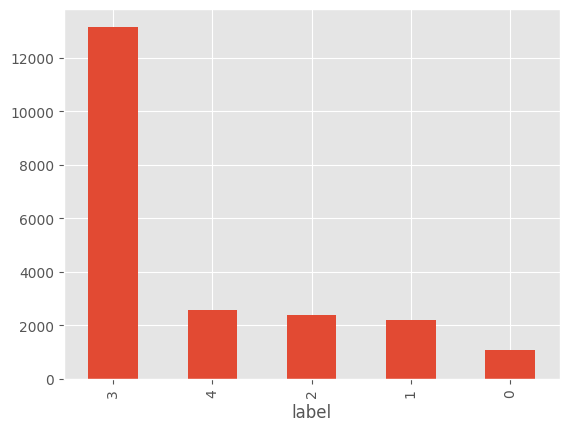

In [12]:
df.label.value_counts().plot(kind="bar")

In [13]:
# train과 test를 9:1로 나눠주세요.
# random_state은 자유롭게 지정 가능합니다.
train_df, valid_df = model_selection.train_test_split(
    df, test_size=0.1, random_state=16, stratify=df.label.values
)

In [14]:
class CassavaDataset(torch.utils.data.Dataset):

    def __init__(self, df, data_path=DATA_PATH, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label

In [15]:
#데이터 증강
transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [16]:
#사용 가능한 ViT 모델 목록
##우리는 이중 vit_base_patch16_224를 사용합니다!
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

Available Vision Transformer Models: 


['vit_7b_patch16_dinov3',
 'vit_base_mci_224',
 'vit_base_patch8_224',
 'vit_base_patch14_dinov2',
 'vit_base_patch14_reg4_dinov2',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_384',
 'vit_base_patch16_clip_224',
 'vit_base_patch16_clip_384',
 'vit_base_patch16_clip_quickgelu_224',
 'vit_base_patch16_dinov3',
 'vit_base_patch16_dinov3_qkvb',
 'vit_base_patch16_gap_224',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_plus_clip_240',
 'vit_base_patch16_reg4_gap_256',
 'vit_base_patch16_rope_224',
 'vit_base_patch16_rope_ape_224',
 'vit_base_patch16_rope_mixed_224',
 'vit_base_patch16_rope_mixed_ape_224',
 'vit_base_patch16_rope_reg1_gap_256',
 'vit_base_patch16_rpn_224',
 'vit_base_patch16_siglip_224',
 'vit_base_patch16_siglip_256',
 'vit_base_patch16_siglip_384',
 'vit_base_patch16_siglip_512',
 'vit_base_patch16_siglip_gap_224',
 'vit_base_patch16_siglip_gap_256',
 'vit_base_patch16_siglip_gap_384',
 'vit_base_patch16_siglip

### 모델 설계
- 클래스 ViTBase16의 각 줄을 설명하는 주석을 달아주세요. (최소 15개)

In [17]:
# 이 셀 안의 코드에 대해서 주석을 달아주세요.
# Vision Transformer(ViT) 기반 분류 모델 정의
class ViTBase16(nn.Module):
    def __init__(self, n_classes, pretrained=False):
        # nn.Module 초기화
        super(ViTBase16, self).__init__()

        # timm 라이브러리에서 ViT-B/16(입력 224, 패치 16x16) 생성
        # 주의: 여기서는 timm의 사전학습 가중치 사용을 끄고(pretrained=False) 생성합니다.
        self.model = timm.create_model("vit_base_patch16_224", pretrained=False)

        # 만약 외부에서 학습된 가중치(체크포인트)를 쓰고 싶다면 MODEL_PATH에서 로드
        # (pretrained=True일 때만 로드; timm 내장 프리트레인은 아님)
        if pretrained:
            self.model.load_state_dict(torch.load(MODEL_PATH))

        # 분류 헤드(최종 Linear)를 과제의 클래스 수에 맞게 교체
        # timm 모델의 head는 in_features(토큰 임베딩 차원) -> n_classes로 연결됨
        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        # 순전파: timm 모델에 입력 전달
        x = self.model(x)
        return x

    def train_one_epoch(self, train_loader, criterion, optimizer, device):
        # 한 에포크 학습 루프에서의 손실/정확도 누적 변수
        epoch_loss = 0.0
        epoch_accuracy = 0.0

        # 모델을 학습 모드로 전환(Dropout, BN 등 학습 동작)
        self.model.train()
        for i, (data, target) in enumerate(train_loader):
            # 장치에 맞게 텐서를 이동
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                # XLA(TPU)에서는 to(device)와 dtype 지정이 권장
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)
            # CPU인 경우는 별도 이동 없이 진행

            # 옵티마이저 기울기 초기화
            optimizer.zero_grad()

            # 순전파 및 손실 계산
            output = self.forward(data)
            loss = criterion(output, target)

            # 역전파로 기울기 계산
            loss.backward()

            # 배치 정확도 계산: 예측 클래스(argmax)와 타깃 비교의 평균
            accuracy = (output.argmax(dim=1) == target).float().mean()

            # 에포크 누적(여기서는 텐서를 그대로 더함; 마지막에 로더 길이로 평균)
            epoch_loss += loss
            epoch_accuracy += accuracy

            if device.type == "xla":
                # XLA에서는 xm.optimizer_step으로 스텝을 커밋해야 함
                xm.optimizer_step(optimizer)

                # 20배치마다 로그 출력(마스터 프로세스만)
                if i % 20 == 0:
                    xm.master_print(f"\tBATCH {i+1}/{len(train_loader)} - LOSS: {loss}")

            else:
                # CUDA/CPU에서는 일반적인 optimizer.step()
                optimizer.step()

        # 에포크 평균 손실/정확도 반환
        return epoch_loss / len(train_loader), epoch_accuracy / len(train_loader)

    def validate_one_epoch(self, valid_loader, criterion, device):
        # 검증 손실/정확도 누적 변수
        valid_loss = 0.0
        valid_accuracy = 0.0

        # 평가 모드 전환(Dropout 비활성, BN 고정)
        self.model.eval()
        for data, target in valid_loader:
            # 장치 이동
            if device.type == "cuda":
                data, target = data.cuda(), target.cuda()
            elif device.type == "xla":
                data = data.to(device, dtype=torch.float32)
                target = target.to(device, dtype=torch.int64)

            # 검증 단계에서는 기울기 계산 비활성화로 메모리/연산 절약
            with torch.no_grad():
                output = self.model(data)
                loss = criterion(output, target)
                accuracy = (output.argmax(dim=1) == target).float().mean()

                # 누적
                valid_loss += loss
                valid_accuracy += accuracy

        # 검증 평균 손실/정확도 반환
        return valid_loss / len(valid_loader), valid_accuracy / len(valid_loader)


In [18]:
def fit_tpu(
    model, epochs, device, criterion, optimizer, train_loader, valid_loader=None
):

    valid_loss_min = np.inf

    train_losses = []
    valid_losses = []
    train_accs = []
    valid_accs = []

    for epoch in range(1, epochs + 1):
        gc.collect()
        para_train_loader = pl.ParallelLoader(train_loader, [device])

        xm.master_print(f"{'='*50}")
        xm.master_print(f"EPOCH {epoch} - TRAINING...")
        train_loss, train_acc = model.train_one_epoch(
            para_train_loader.per_device_loader(device), criterion, optimizer, device
        )
        xm.master_print(
            f"\n\t[TRAIN] EPOCH {epoch} - LOSS: {train_loss}, ACCURACY: {train_acc}\n"
        )
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        gc.collect()

        if valid_loader is not None:
            gc.collect()
            para_valid_loader = pl.ParallelLoader(valid_loader, [device])
            xm.master_print(f"EPOCH {epoch} - VALIDATING...")
            valid_loss, valid_acc = model.validate_one_epoch(
                para_valid_loader.per_device_loader(device), criterion, device
            )
            xm.master_print(f"\t[VALID] LOSS: {valid_loss}, ACCURACY: {valid_acc}\n")
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)
            gc.collect()

            if valid_loss <= valid_loss_min and epoch != 1:
                xm.master_print(
                    "Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...".format(
                        valid_loss_min, valid_loss
                    )
                )

            valid_loss_min = valid_loss

    return {
        "train_loss": train_losses,
        "valid_losses": valid_losses,
        "train_acc": train_accs,
        "valid_acc": valid_accs,
    }

In [19]:
model = ViTBase16(n_classes=5, pretrained=True)

/tmp/ipython-input-3879882131.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(MODEL_PATH))


In [20]:
def _run():
    train_dataset = CassavaDataset(train_df, transforms=transforms_train)
    valid_dataset = CassavaDataset(valid_df, transforms=transforms_valid)

    train_sampler = torch.utils.data.distributed.DistributedSampler(
        train_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=True,
    )

    valid_sampler = torch.utils.data.distributed.DistributedSampler(
        valid_dataset,
        num_replicas=xm.xrt_world_size(),
        rank=xm.get_ordinal(),
        shuffle=False,
    )

    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        drop_last=True,
        num_workers=8,
    )

    valid_loader = torch.utils.data.DataLoader(
        dataset=valid_dataset,
        batch_size=BATCH_SIZE,
        sampler=valid_sampler,
        drop_last=True,
        num_workers=8,
    )

    criterion = nn.CrossEntropyLoss()  #cross entropy loss로 설정.
    device = xm.xla_device()
    model.to(device)

    lr = LR * xm.xrt_world_size()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    xm.master_print(f"INITIALIZING TRAINING ON {xm.xrt_world_size()} TPU CORES")
    start_time = datetime.now()
    xm.master_print(f"Start Time: {start_time}")

    logs = fit_tpu(
        model=model,
        epochs=N_EPOCHS,
        device=device,
        criterion=criterion,
        optimizer=optimizer,
        train_loader=train_loader,
        valid_loader=valid_loader,
    )

    xm.master_print(f"Execution time: {datetime.now() - start_time}")

    xm.master_print("Saving Model")
    xm.save(
        model.state_dict(), f'model_5e_{datetime.now().strftime("%Y%m%d-%H%M")}.pth'
    )

In [21]:
# Training 시작
def _mp_fn(rank, flags):
    torch.set_default_tensor_type("torch.FloatTensor")
    a = _run()


# Run
FLAGS = {}
xmp.spawn(_mp_fn, args=(FLAGS,), nprocs=1, start_method="fork")

NameError: name 'xmp' is not defined

torch_xla 라이브러리에서 오류가 생겼는데 해결하지 못했습니다 ㅠㅠ